In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='dark', font_scale=1.25)
pd.set_option('display.max_columns', None)

In [2]:
o3 = pd.read_csv('o3.csv')
pm25 = pd.read_csv('pm25.csv')
co = pd.read_csv('co.csv')
covid = pd.read_csv('statewide_cases.csv')

In [3]:
def plot_aqi_trend(air, covid, aqi, location='San Diego', window=30, avg_given=True):
    '''
    Plot line plots based on the moving average of given air quality and covid data.
    :param air: dataset of air quality index of an air pollutant
    :param covid: dataset of covid cases
    :param aqi: column name of the aqi value
    :param location: county name to observe
    :param window: size of the moving average window
    :param avg_given: whether 5 year average is given in the data
    :type air: Pandas DataFrame
    :type covid: Pandas DataFrame
    :type aqi: str
    :type location: str
    :type window: int
    :type avg_given: bool
    :returns: None
    '''
    assert isinstance(air, pd.DataFrame), 'data must be in pandas DataFrame'
    assert isinstance(covid, pd.DataFrame), 'data must be in pandas DataFrame'
    assert isinstance(aqi, str) and aqi in air.columns, 'aqi must be a string corresponding to polluant aqi values'
    assert isinstance(location, str) and location in covid['county'].unique(), 'location must be a string of available county'
    assert isinstance(window, int) and window > 0, 'window must be a positive integer'
    
    # prepare air data
    air['Date'] = pd.to_datetime(air['Date'])
    air = air.sort_values(by='Date')
    air['Moving Average'] = air[aqi].rolling(window=window, center=True).mean()
    if avg_given:
        air['5-year-avg Moving Average'] = air['5-year Average (2015-2019)'].astype(float).rolling(window=window, center=True).mean()
    air = air[air['Moving Average'].notna()]
    tick_min = 0
    tick_max = int(round(np.max(air['Moving Average']), -1) + 10)
    tick_len = int(tick_max / 10)
    tick_range = np.linspace(tick_min, tick_max, tick_len+1)
    factor = aqi.split(' ')[0]
    
    # prepare covid data
    covid = covid.loc[covid['county'] == location]
    covid['date'] = pd.to_datetime(covid['date'])
    covid = covid.sort_values(by='date')
    covid['Moving Average'] = covid['newcountconfirmed'].rolling(window=window, center=True).mean()
    covid = covid[covid['Moving Average'].notna()]
    
    # line plots
    fig, ax1 = plt.subplots(figsize=(15,7.5))
    ax2 = ax1.twinx()
    title = '{} {} vs COVID19 Cases {}-Day Moving Average'.format(location, factor, window)
    sns.lineplot(data=air, x='Date', y='Moving Average', ax=ax1, color='b', label='{}'.format(factor)).set_title(title)
    if avg_given:
        sns.lineplot(data=air, x='Date', y='5-year-avg Moving Average', ax=ax1, color='y', label='{} 5-yr avg'.format(factor))
    sns.lineplot(data=covid, x='date', y='Moving Average', ax=ax2, color='r', label='COVID19')
    dates = ['2020-2-26','2020-3-19','2020-5-14','2020-8-18','2020-11-21','2020-12-11']
    pos = [tick_max-i*2 for i in range(6,-1,-1)]
    events = ['First case in CA', 'Stay home order', 'CDC guidelines released', 'CA wildfire', 'Limited stay home order', 'Vaccines approved']
    for date, event, y in zip(dates, events, pos):
        ax1.axvline(x=date, ls=':')
        ax1.text(date, y, event)
    ax1.set_ylabel('{} Air Quality Index Level'.format(factor))
    ax2.set_ylabel('COVID-19 Daily Confirmed Cases')
    ax1.set_yticks(tick_range)
    ax1.axhspan(50, 100, color='bisque')
    ax1.axhspan(100, tick_max, color='coral')
    fig.legend(loc='upper left', bbox_to_anchor=(0.125, 0.875))
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    plt.show()
    fig.savefig('{}.png'.format(factor))

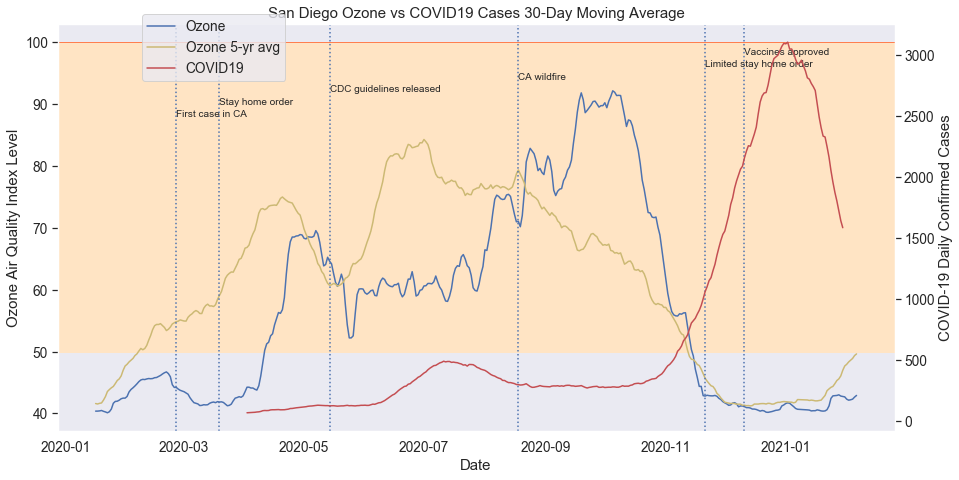

In [4]:
plot_aqi_trend(o3, covid, aqi='Ozone AQI Value')

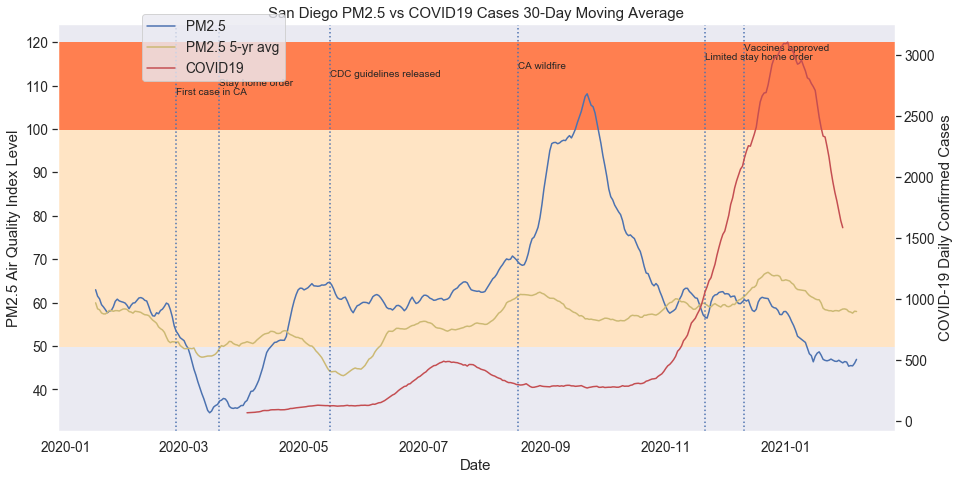

In [5]:
plot_aqi_trend(pm25, covid, aqi='PM2.5 AQI Value')